**Lưu ý:** Dữ liệu trong source code này không phải dữ liệu thật và không có ý nghĩa phản ánh các con số thực tế.

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random

# Cài đặt hàm và công thức

In [ ]:
def make_label_dict(labels):
    l = {}
    for i, label in enumerate(labels):
        l[i] = label
    return l

In [ ]:
#Class đồ thị thành phố
class Graph(object):
    # Initialize the matrix
    def __init__(self, size,labels):
        self.adjMatrix = np.zeros((size,size),dtype='int')
        self.labels=labels
        self.Ss = []
        self.Is = []
        self.Rs = []
        self.beta = np.full(size, 0.02)
        self.gamma = np.full(size, 0.04)
        for i in range(0,size):
          self.Ss.append([])
          self.Is.append([])
          self.Rs.append([])
          for j in range(0,size):
            if (i!=j):
              self.adjMatrix[i][j] = 1000
        self.size = size
    # Init value for city n
    def init_city(self,n,S,I,R,beta,gamma):
      self.Ss[n].append(S) 
      self.Is[n].append(I)
      self.Rs[n].append(R)
      self.beta[n] = beta
      self.gamma[n] = gamma

    # Get matrix's length
    def __len__(self):
        return self.size

    # Print the matrix
    def print_matrix(self):
        for row in self.adjMatrix:
            for val in row:
                print('{:20}'.format(val),end=';')
            print('\n')
    # Visualize the matrix
    def plot_matrix(self):
      G=nx.Graph(self.adjMatrix)
      labels=make_label_dict(self.labels)
      edge_labels = dict( ((u, v), d["weight"]) for u, v, d in G.edges(data=True) )
      pos = nx.fruchterman_reingold_layout(G)
      nx.draw(G, pos)
      nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
      nx.draw(G,pos,node_size=1000, labels=labels, with_labels=True,node_color="orange",
              font_weight="bold",linewidths=4, font_size=10)
      
    # Plot SIR graph for each country
    def plot_sir(self):
      number_of_cols=2
      fig, axs = plt.subplots(int(len(self)/number_of_cols),number_of_cols,figsize=(15,12),sharex=True)
      x=np.arange(0,300,1)
      for i in range(len(self)):
        axs[int(i/number_of_cols)][i%number_of_cols].plot(x, self.Ss[i], label = "S")
        axs[int(i/number_of_cols)][i%number_of_cols].plot(x, self.Is[i], label = "I")
        axs[int(i/number_of_cols)][i%number_of_cols].plot(x, self.Rs[i], label = "R")
        axs[int(i/number_of_cols)][i%number_of_cols].set(xlabel='days')
        axs[int(i/number_of_cols)][i%number_of_cols].set(title=self.labels[i])
        axs[int(i/number_of_cols)][i%number_of_cols].set(ylabel='population')
        axs[int(i/number_of_cols)][i%number_of_cols].grid()
        axs[int(i/number_of_cols)][i%number_of_cols].legend()

    # Plot SIR graph for all countries on the graph
    def plot_sir_total(self,title=None):
      SumS=[]
      SumI=[]
      SumR=[]
      for day in range(0,300):
        Sss=0
        Iss=0
        Rss=0
        for i in range(0,len(self)):
          Sss+=self.Ss[i][day]
          Iss+=self.Is[i][day]
          Rss+=self.Rs[i][day]
        SumS.append(Sss)
        SumI.append(Iss)
        SumR.append(Rss)
      fig3, axs3 = plt.subplots(1,1,figsize=(10,4))
      x=np.arange(0,300,1)
      axs3.plot(x, SumS, label = "S")
      axs3.plot(x, SumI, label = "I")
      axs3.plot(x, SumR, label = "R")
      axs3.set(ylabel='population')
      axs3.set(xlabel='days')
      axs3.set(title=title)
      axs3.grid()
      axs3.legend()

In [ ]:
#Hàm tính đạo hàm cho model SIR 
#S: Susceptible, I: Infected, R: Recovered
#beta: transmission rate, gamma: recover rate
def derivative(S,I,R,beta,gamma):
  N=S+I+R
  dSt=-(beta*I*S)/N
  dIt=beta*I*S/N-gamma*I
  dRt=gamma*I
  return dSt, dIt, dRt
# Hàm tính dân số
def population(self, k, day):
  return (self.Ss[k][day]+self.Is[k][day]+self.Rs[k][day])

In [ ]:
#Cập nhật SIR từng thành phố trong g, số ngày là day với công thức ở dưới
def graph_SIR(g,day,alpha):
  for i in range (len(g)):
    a = derivative(g.Ss[i][day-1],g.Is[i][day-1],g.Rs[i][day-1],0.2,g.gamma[i])
    sum_transport=0
    sum_mobility=0
    for k in range (len(g)):
      sum_transport+= alpha*g.Ss[i][day-1]*g.adjMatrix[k][i] * (g.Is[k][day - 1] / population(g, k, day-1)) * g.beta[k]
      sum_mobility+= g.adjMatrix[k][i]
    g.Ss[i].append(g.Ss[i][day-1]+a[0]-sum_transport/(population(g,i,day-1) + sum_mobility))
    g.Is[i].append(g.Is[i][day-1]+a[1]+sum_transport/(population(g,i,day-1) + sum_mobility))
    g.Rs[i].append(g.Rs[i][day-1]+a[2])

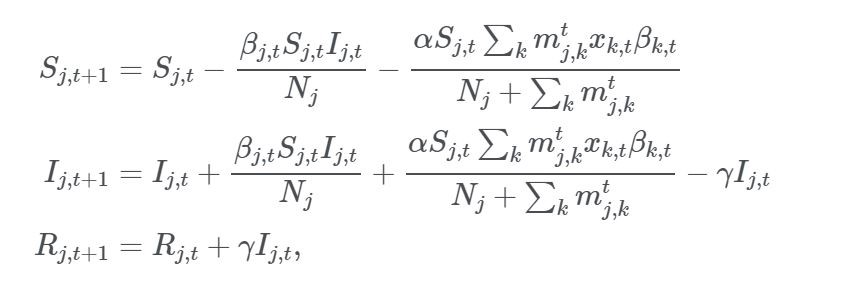

# Khởi tạo bản đồ

Ta sẽ khởi tạo đồ thị trong đó Hồ Chí Minh là thành phố trung tâm và là nơi có người bị nhiễm bệnh đầu tiên, tất cả các thành phố khác không bị nhiễm bệnh

In [ ]:
#Hàm tạo ra một graph mẫu gồm 6 quốc gia với đường đi được chỉnh sửa.
def init_sample_graph():
  # Create a new graph
  g=Graph(6,['Long An','Ho Chi Minh','Binh Duong','Dong Nai','Vung Tau','Tiền Giang'])

  # Change some edges
  # Xóa các cạnh sao cho Long An chỉ nối đến Hồ Chí Minh
  g.adjMatrix[0][4]=0
  g.adjMatrix[4][0]=0
  g.adjMatrix[3][0]=0
  g.adjMatrix[0][3]=0
  g.adjMatrix[2][0]=0
  g.adjMatrix[0][2]=0

  # Xóa các cạnh sao cho Tiền Giang chỉ nối đến Long An
  g.adjMatrix[5][1]=0
  g.adjMatrix[1][5]=0
  g.adjMatrix[5][2]=0
  g.adjMatrix[2][5]=0
  g.adjMatrix[5][3]=0
  g.adjMatrix[3][5]=0
  g.adjMatrix[5][4]=0
  g.adjMatrix[4][5]=0
  return g

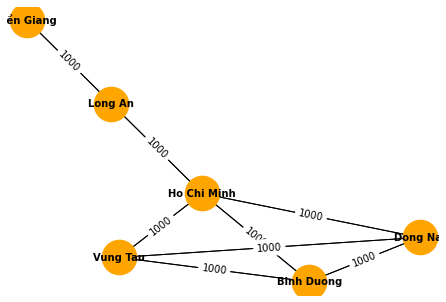

In [ ]:
g=init_sample_graph()
# Change initialize SIR for each city
beta=1.5
g.init_city(0,1000000,0,0,beta,1/30) #Long An
g.init_city(1,5000000,1,0,beta,1/30) #Ho Chi Minh, một người nhiễm
g.init_city(2,500000,0,0,beta,1/30) #Binh Duong
g.init_city(3,2000000,0,0,beta,1/30) #Dong Nai
g.init_city(4,1000000,0,0,beta,1/30) #Vung Tau
g.init_city(5,1000000,0,0,beta,1/30) #Tien Giang
# Plot
plot=g.plot_matrix()

# Sự ảnh hưởng do khoảng cách từ thành phố tới tâm dịch.

In [ ]:
# Tính SIR của từng ngày trong 300 ngày
alpha=0.01
for t in np.arange(1,300,1):
   graph_SIR(g,t,alpha)

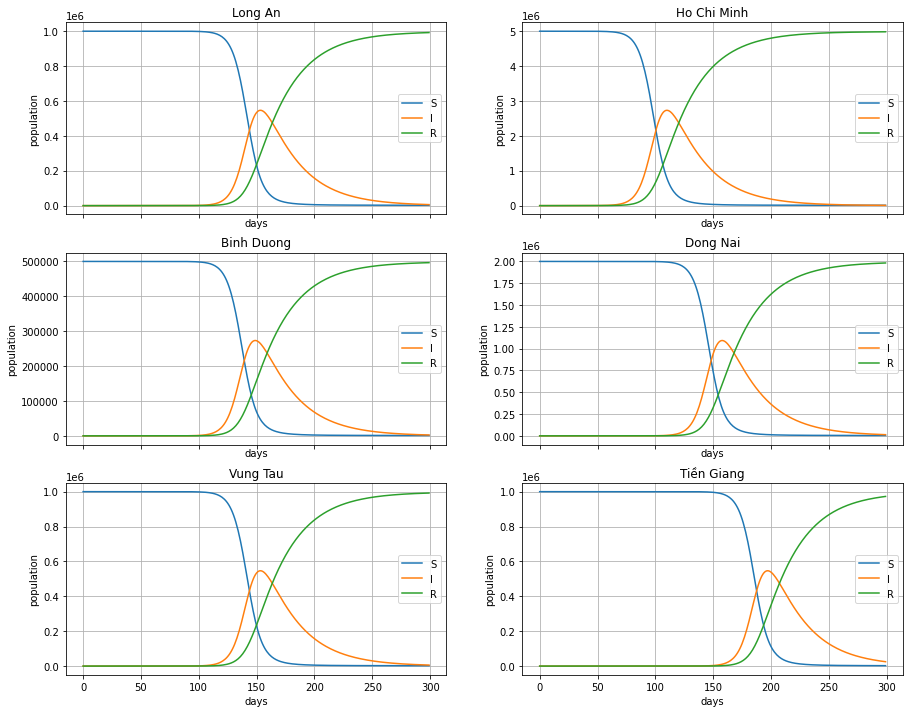

In [ ]:
# Vẽ biểu đồ SIR của từng thành phố
g.plot_sir()

Qua hình trên chúng ta thấy rằng:
* Hồ Chí Minh là tâm dịch, nơi dịch bùng phát nên số lượng người bị nhiễm bệnh đạt đỉnh điểm rất sớm vào khoảng hơn 100 ngày.
* Các thành phố cận kề với Hồ Chí Minh đạt đỉnh điểm dịch vào khoảng 150 ngày.
* Tiền Giang không giáp trực tiếp với Hồ Chí Minh nên dịch đạt đỉnh điểm vào khoảng gần 200 ngày.

Ta thấy rằng khoảng cách của một địa điểm so với tâm dịch có vai trò quan trọng trong việc xác định ngày đạt đỉnh điểm.

Phần trăm của dân số bị nhiễm tối đa hầu như không có sự khác biệt giữa các thành phố. Lý do là phần trăm dân số bị nhiễm bị ảnh hưởng bởi $\beta$ và $\gamma$ chứ không phải $\alpha$. Mặc dù vậy nhưng trong thực tế $\alpha$ là rất quan trọng vì đẩy lùi ngày dịch đạt đỉnh điểm giúp cho quốc gia, khu vực có thêm thời gian để lên kế hoạch đối phó với dịch bệnh hơn. Và sau một khoảng thời gian, sau khi thuốc/ vắc xin được sản xuất sẽ làm cho $\beta$ và $\gamma$ thay đổi. Và đỉnh điểm dịch lúc đó sẽ thấp hơn. Cho nên $\alpha$ sẽ làm giảm phần trăm dân số bị nhiễm.

Ta giả sử vào ngày thứ 100 đã phát minh ra loại thuốc khiến cho tỷ lệ hồi phục cao hơn. ( $\gamma=\frac{1}{31} \Longrightarrow \gamma=\frac{1}{15} $)

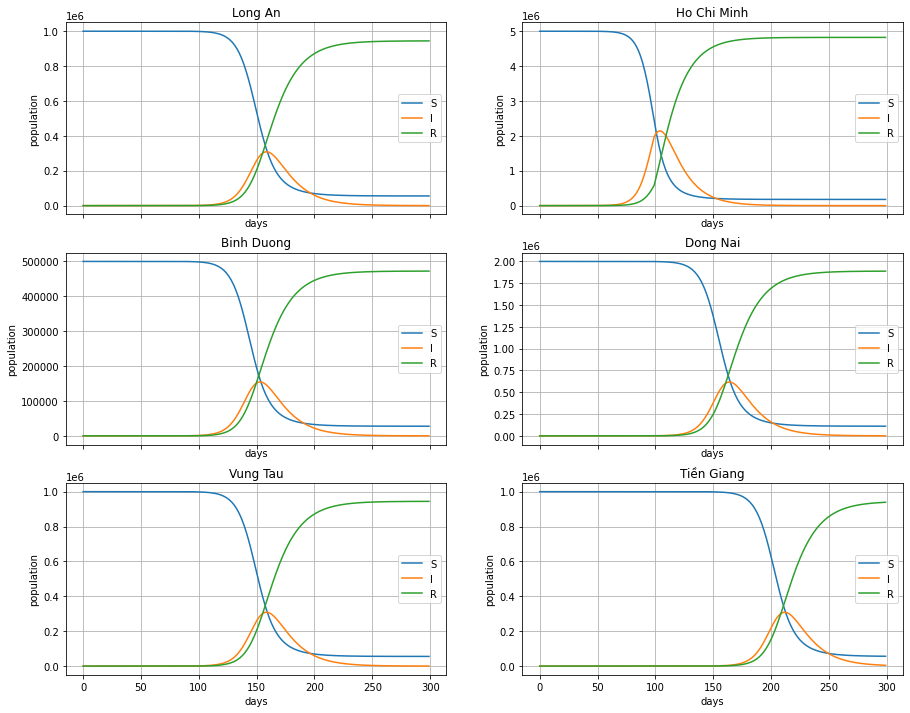

In [ ]:
g=init_sample_graph()

# Change initialize SIR for each city
beta=1.5
g.init_city(0,1000000,0,0,beta,1/30)
g.init_city(1,5000000,1,0,beta,1/30)
g.init_city(2,500000,0,0,beta,1/30) 
g.init_city(3,2000000,0,0,beta,1/30) 
g.init_city(4,1000000,0,0,beta,1/30) 
g.init_city(5,1000000,0,0,beta,1/30)

# Tính SIR của từng ngày
alpha=0.01
for t in np.arange(1,300,1):
  #Vào ngày 100
  if t==100:
    #Tất cả các nước có vắc xin/ thuốc làm gamma thay đổi
    g.gamma=np.full(len(g), 1/15)
  graph_SIR(g,t,alpha)
g.plot_sir()

Chúng ta có thể thấy rằng tỉ lệ dân số bị nhiễm giảm ít trong Hồ Chí Minh và giảm nhiều ở các thành phố khác.

# Mô phỏng cách ly thành phố lớn / tâm dịch

Liệu cách ly tâm dịch có giúp làm giảm dịch bệnh? Ta sẽ thử chạy 2 mô hình và so sánh kết quả:
* Mô hình bình thường.
* Mô hình có trọng số các đường đi ra vào thành phố Hồ Chí Minh bị giảm mạnh

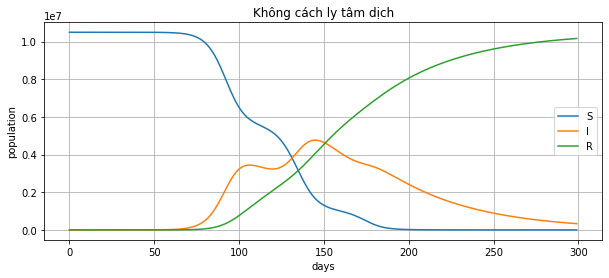

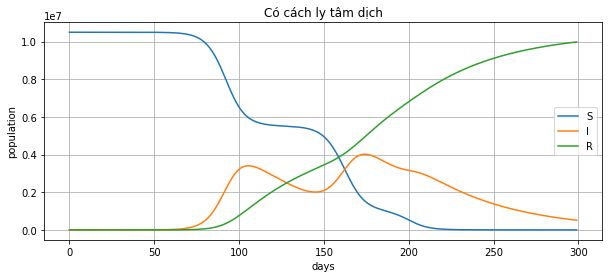

In [ ]:
#Case 1: Không cách ly tâm dịch.
g1=init_sample_graph()

#Case 2: Cách ly tâm dịch
g2=init_sample_graph()

# Tâm dịch HCM bị giãn cách, ít giao lưu với các thành phố khác.
g2.adjMatrix[0][1]=10
g2.adjMatrix[1][0]=10
g2.adjMatrix[2][1]=10
g2.adjMatrix[1][2]=10
g2.adjMatrix[3][1]=10
g2.adjMatrix[1][3]=10
g2.adjMatrix[4][1]=10
g2.adjMatrix[1][4]=10

#Các hệ số khác không đổi ở 2 case
beta=1.5
g1.init_city(0,1000000,0,0,beta,1/50) #Long An
g1.init_city(1,5000000,1,0,beta,1/50) #Ho Chi Minh, 1 nguoi nhiem
g1.init_city(2,500000,0,0,beta,1/50) #Binh Duong
g1.init_city(3,2000000,0,0,beta,1/50) #Dong Nai
g1.init_city(4,1000000,0,0,beta,1/50) #Vung Tau
g1.init_city(5,1000000,0,0,beta,1/50) #Tien Giang

g2.init_city(0,1000000,0,0,beta,1/50) #Long An
g2.init_city(1,5000000,1,0,beta,1/50) #Ho Chi Minh, 1 nguoi nhiem
g2.init_city(2,500000,0,0,beta,1/50) #Binh Duong
g2.init_city(3,2000000,0,0,beta,1/50) #Dong Nai
g2.init_city(4,1000000,0,0,beta,1/50) #Vung Tau
g2.init_city(5,1000000,0,0,beta,1/50) #Tien Giang

# Tính SIR của từng ngày
alpha=0.01
for t in np.arange(1,300,1):
  graph_SIR(g1,t,alpha)
for t in np.arange(1,300,1):
  graph_SIR(g2,t,alpha)
g1.plot_sir_total("Không cách ly tâm dịch")
g2.plot_sir_total("Có cách ly tâm dịch")

Theo quan sát thì có cách ly tâm dịch sẽ không những giúp đẩy lùi ngày đạt đỉnh điểm mà còn làm giảm tổng dân số bị nhiễm.

# Giãn cách tất cả các vùng - Tầm quan trọng của $\alpha$

$\alpha$ là hệ số ảnh hưởng giữa các thành phố với nhau. $\alpha$ càng lớn thì dịch càng dễ lây lan. $\alpha$ có thể được giảm trên thực tế bằng biện pháp giãn cách, kiểm duyệt đường đi giữa các vùng chặt chẽ. Vậy việc giảm $\alpha$ có ích như thế nào? Ta sẽ tiếp tục chạy 2 mô hình và so sánh

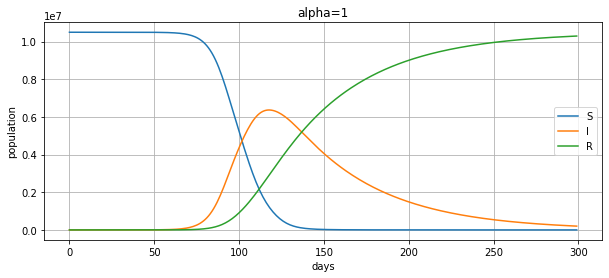

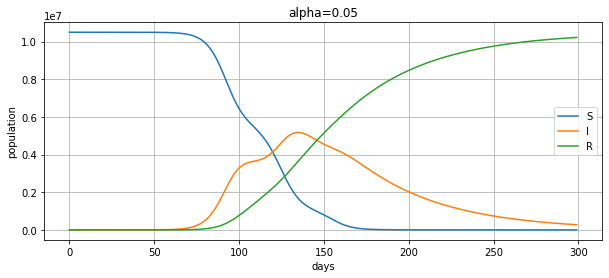

In [ ]:
#Case 1: Không giãn cách giữa các vùng
g1=init_sample_graph()

#Case 2: Có giãn cách giữa các vùng 
g2=init_sample_graph()

#Các hệ số khác không đổi ở 2 case
beta=1.5
g1.init_city(0,1000000,0,0,beta,1/50) #Long An
g1.init_city(1,5000000,1,0,beta,1/50) #Ho Chi Minh, 1 nguoi nhiem
g1.init_city(2,500000,0,0,beta,1/50) #Binh Duong
g1.init_city(3,2000000,0,0,beta,1/50) #Dong Nai
g1.init_city(4,1000000,0,0,beta,1/50) #Vung Tau
g1.init_city(5,1000000,0,0,beta,1/50) #Tien Giang

g2.init_city(0,1000000,0,0,beta,1/50) #Long An
g2.init_city(1,5000000,1,0,beta,1/50) #Ho Chi Minh, 1 nguoi nhiem
g2.init_city(2,500000,0,0,beta,1/50) #Binh Duong
g2.init_city(3,2000000,0,0,beta,1/50) #Dong Nai
g2.init_city(4,1000000,0,0,beta,1/50) #Vung Tau
g2.init_city(5,1000000,0,0,beta,1/50) #Tien Giang

# Tính SIR của từng ngày với alpha khác nhau.
for t in np.arange(1,300,1):
  graph_SIR(g1,t,1)
for t in np.arange(1,300,1):
  graph_SIR(g2,t,0.05)
g1.plot_sir_total("alpha=1")
g2.plot_sir_total("alpha=0.05")

Đúng là giảm $\alpha$ sẽ làm giảm đi sự lây lan của dịch bệnh.

# Tổng kết
Từ chạy thực nghiệm trên soure code chúng ta đã thấy được sự ảnh hưởng của các thông số đồ thị và mô hình được sự hiệu quả của các biện pháp giãn cách xã hội trong việc đầy lùi ngày dịch đạt đỉnh và làm giảm số lượng người bị nhiễm. Tuy nhiên đây là một mô hình vẫn đang được thử nghiệm và chưa áp dụng vào các con số thực tế. 